<a href="https://colab.research.google.com/github/mlubega/cv/blob/master/RecognizeFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Please execute each cell in order to install the necessary functions and models

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Enable CUDA GPU
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
#Install necessary libraries

!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
!pip install tensorflow-gpu
!pip install --upgrade tensorflow
!pip install h5py
!pip install keras
!pip install keras-preprocessing
!pip install h5py 

     |████████████████████████████████| 345.2MB 53kB/s 
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.13.1)


In [0]:
import cv2
import numpy as np
import os
from sklearn import svm
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from keras.models import load_model
import time
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [0]:
'''
get_image()

This method accepts only four file types ['.mp4', '.mov','.jpg','.jpeg' ]

input: filepath
output: image or single frame for video


'''

def get_image(filepath):

  if not filepath:
    raise ValueError("No file path given")

  img = None
  ftype = os.path.splitext(filepath)[-1]


  # process img
  if ftype in IMG_EXTS:
      img = cv2.imread(filepath)

  #process video
  elif ftype in VID_EXTS: 
      cap = cv2.VideoCapture(filepath)

      if not cap.isOpened:
          sys.exit('Video Capture Not Open')  # how to handle?

      total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      for i in range(total_frames):
          hasframe, frame = cap.read()

          if not hasframe:
               continue;
          if filepath.endswith('.mov'):
               frame = imutils.rotate_bound(frame, 90)

          img = frame
          break;
  else:
      raise ValueError("Invalid file extension")
      
  if img == None:
    raise FileNotFoundError("Unable to read file")
    
  smaller_img = cv2.resize(img, None, fx=0.15, fy=0.15)

  return smaller_img

In [0]:
# Load trained models, bag of features, and CNN label map 
%cd /content/drive/My\ Drive/City\ Msc\ Data\ Science/ComputerVision/Coursework2019/models


model_orbMLP = joblib.load("model_orbMLP.pkl")
model_orbSVM = joblib.load("model_orbSVM.pkl")

model_siftMLP = joblib.load("model_siftMLP.pkl")
model_siftSVM = joblib.load("model_siftSVM.pkl")

model_surfMLP = joblib.load("model_surfMLP.pkl")
model_surfSVM = joblib.load("model_surfSVM.pkl")

model_cnn = load_model("model_VGG16.h5")
labelmap = joblib.load("cnn_labelmap.pkl")

orbBAG_kmeans = joblib.load("orbBAG_kmeans.pkl")
siftBAG_kmeans = joblib.load("siftBAG_kmeans.pkl")
surfBAG_kmeans = joblib.load("surfBAG_kmeans.pkl")

/content/drive/My Drive/City Msc Data Science/ComputerVision/Coursework2019/models
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
# Instantiate Helper Functions and Variables
%cd /content/drive/My\ Drive/City\ Msc\ Data\ Science/ComputerVision/Coursework2019 #must be in this folder to properly load Haar Cascades 


sift = cv2.xfeatures2d.SIFT_create()
surf = cv2.xfeatures2d.SURF_create()
orb = cv2.ORB_create()


K = 69 * 5

def getSIFTfeatures(gray_img):
    #sift = cv2.xfeatures2d.SIFT_create() #What threshold?
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def getSURFfeatures(gray_img):  
    #surf = cv2.xfeatures2d.SURF_create() #what threshold?
    surf.setExtended(True) # --> to expand to 128 dim.
    kp, desc = surf.detectAndCompute(gray_img, None)
    return kp, desc

def getORBfeatures(gray_img):
    # Initiate ORB detector
    #orb = cv2.ORB_create()
    # find the keypoints with ORB
    kp = orb.detect(gray_img,None)
    # compute the descriptors with ORB
    kp, desc = orb.compute(gray_img, kp)
    return kp, desc
  
def detectFaceAndCrop(img):
  
    crop_list = []
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_detector = cv2.CascadeClassifier('/content/drive/My Drive/City Msc Data Science/ComputerVision/Coursework2019/haarcascade_frontalface_default.xml')
    faces = face_detector.detectMultiScale(gray, 1.3, 5,  minSize=(80, 80))
    for (x,y,w,h) in faces:     
      crop = img[y:y+h, x:x+w]
      crop_list.append(crop)
      
    return faces, crop_list

def getFeatures(crop, featureFunc):
    kp, desc = featureFunc(crop)
    return desc

def getHistogram(desc_list, kmeans_centers):
    preds = kmeans_centers.predict(desc_list)
    hist, bin_edges=np.histogram(preds, bins=range(0, K))  
    return hist
  
def get_class(preds):
    pred_idx = np.argmax(preds, axis=-1)
    class_pred = labelmap[pred_idx[0]]
  
    return class_pred

def transform_for_cnn(img):

    img = cv2.resize(img, (224,224))
    img_tensor = np.expand_dims(img, axis=0)  # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    
    return img_tensor


[Errno 2] No such file or directory: '/content/drive/My Drive/City Msc Data Science/ComputerVision/Coursework2019 #must be in this folder to properly load Haar Cascades'
/content/drive/My Drive/City Msc Data Science/ComputerVision/Coursework2019/images


In [0]:
# Recognise Face Model Lookup Tables
feature_types = {'orb':getORBfeatures, 'sift':getSIFTfeatures, 'surf':getSURFfeatures}
bovw = {'orb': orbBAG_kmeans, 'sift':siftBAG_kmeans, 'surf':surfBAG_kmeans}
models = {'cnn':model_cnn,
          'svm':{'orb':model_orbSVM, 'sift':model_siftSVM, 'surf':model_surfSVM},
          'mlp':{'orb':model_orbMLP, 'sift':model_siftMLP, 'surf':model_surfMLP}}


valid_classifiers =  ['mlp', 'svm', 'cnn']
valid_features = ['orb', 'sift', 'surf', '']


'''
'''

def recognize_face(img, feature, classifier):
  
 
    if (classifier not in valid_classifiers):
      raise ValueError("Invalid Classifer. Available Options:", valid_classifiers)
    if (feature not in valid_features):
      raise ValueError("Invalid Feature. Available Options:", valid_features)

    bboxes, crop_list = detectFaceAndCrop(img)
    
    if not crop_list:
      return [], img
    
    prediction_matrix = []
    
    
    if classifier != 'cnn':
      gray_crop = [ cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in crop_list]
      descriptors = [ getFeatures(x, feature_types[feature]) for x in gray_crop ]
      histograms = [ getHistogram(x, bovw[feature]) for x in descriptors ]
      model = models[classifier][feature]
      predictions = model.predict(histograms)
    
    elif classifier == 'cnn':
      model = models['cnn']
      crops_resized = [transform_for_cnn(x) for x in crop_list]
      softmaxes = [ model.predict(x) for x in crops_resized]
      predictions = [ get_class(x) for x in softmaxes ]
      
    else:
      raise ValueError('Unsupported Type')
      
    out = img.copy()
    for idx, box in enumerate(bboxes):
      (x, y, w, h) = box
      prediction = predictions[idx]
      cv2.rectangle(out, (x, y), (x+w,y+h), (0, 0, 255), 2)
      cv2.putText(out, predictions[idx], (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
      prediction_matrix.append([prediction, x, y])
    
    
    return np.array(prediction_matrix), out
    


# How to use recognize_face() on a single image

/content/drive/My Drive/City Msc Data Science/ComputerVision/Coursework2019/images
[['3' '188' '131']]


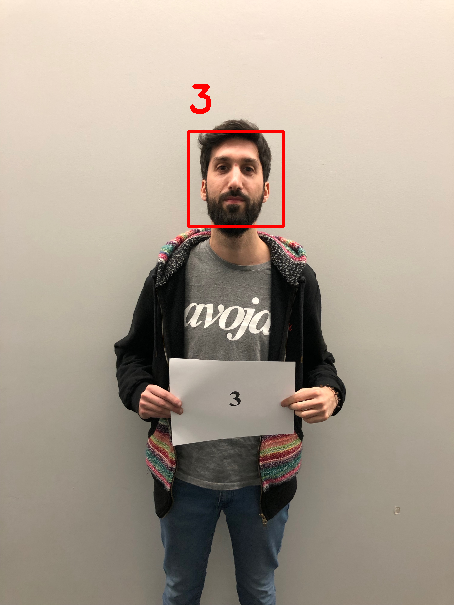

In [0]:
# Navigate to directory with images
%cd /content/drive/My\ Drive/City\ Msc\ Data\ Science/ComputerVision/Coursework2019/images/

daniel = cv2.imread('daniel.jpeg') # <-----insert image name directly
dan = cv2.resize(daniel, None, fx=0.15, fy=0.15) #resize images since using cv2_imshow to show full size images takes a long time
matrix1, img  = recognize_face(dan, 'sift' , 'svm')  # <-----specify feature & model combination
print(matrix1)
cv2_imshow(img)

# How to use recognize_face() on a directory of images

[] [] [] [] [] [] []


[['11' '241' '168']] [['44' '241' '168']] [['44' '241' '168']] [['11' '241' '168']] [['11' '241' '168']] [['53' '241' '168']] [['11' '241' '168']]


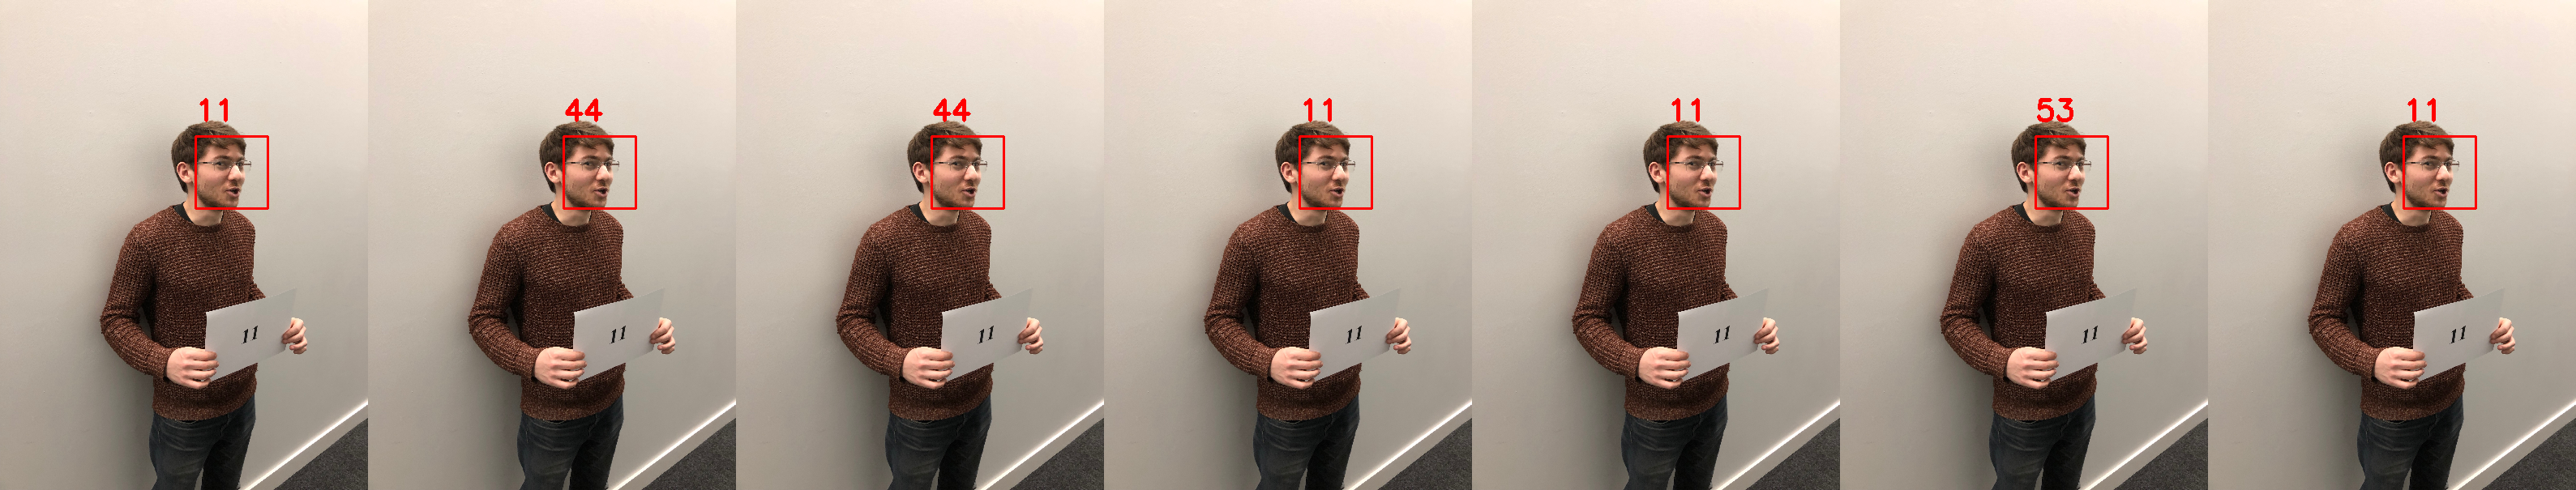

[['11' '188' '196']] [['37' '188' '196']] [['50' '188' '196']] [['11' '188' '196']] [['37' '188' '196']] [['56' '188' '196']] [['17' '188' '196']]


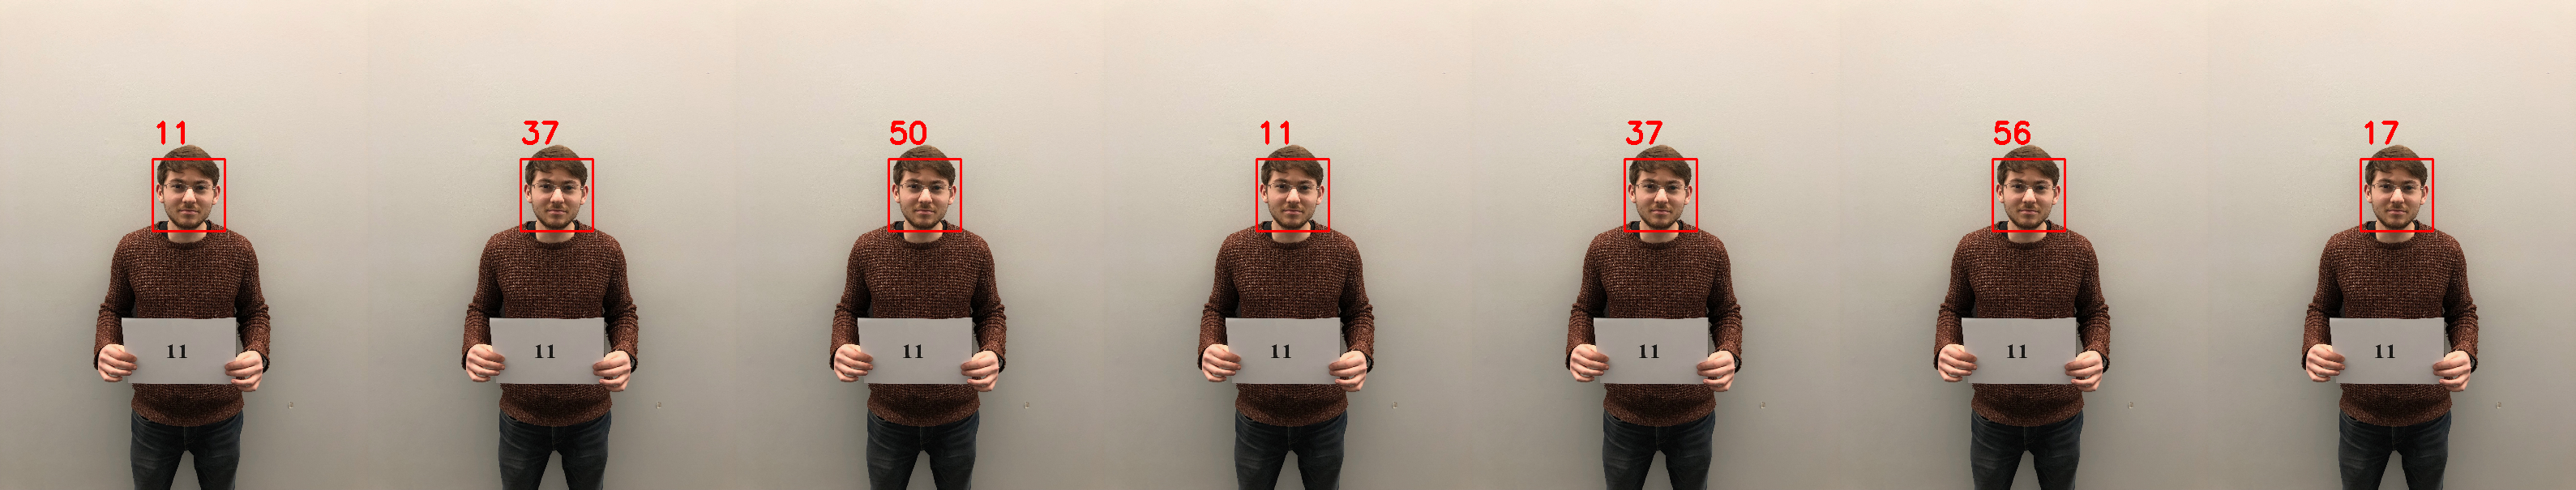

[['1' '158' '110']] [['1' '158' '110']] [['1' '158' '110']] [['1' '158' '110']] [['1' '158' '110']] [['1' '158' '110']] [['17' '158' '110']]


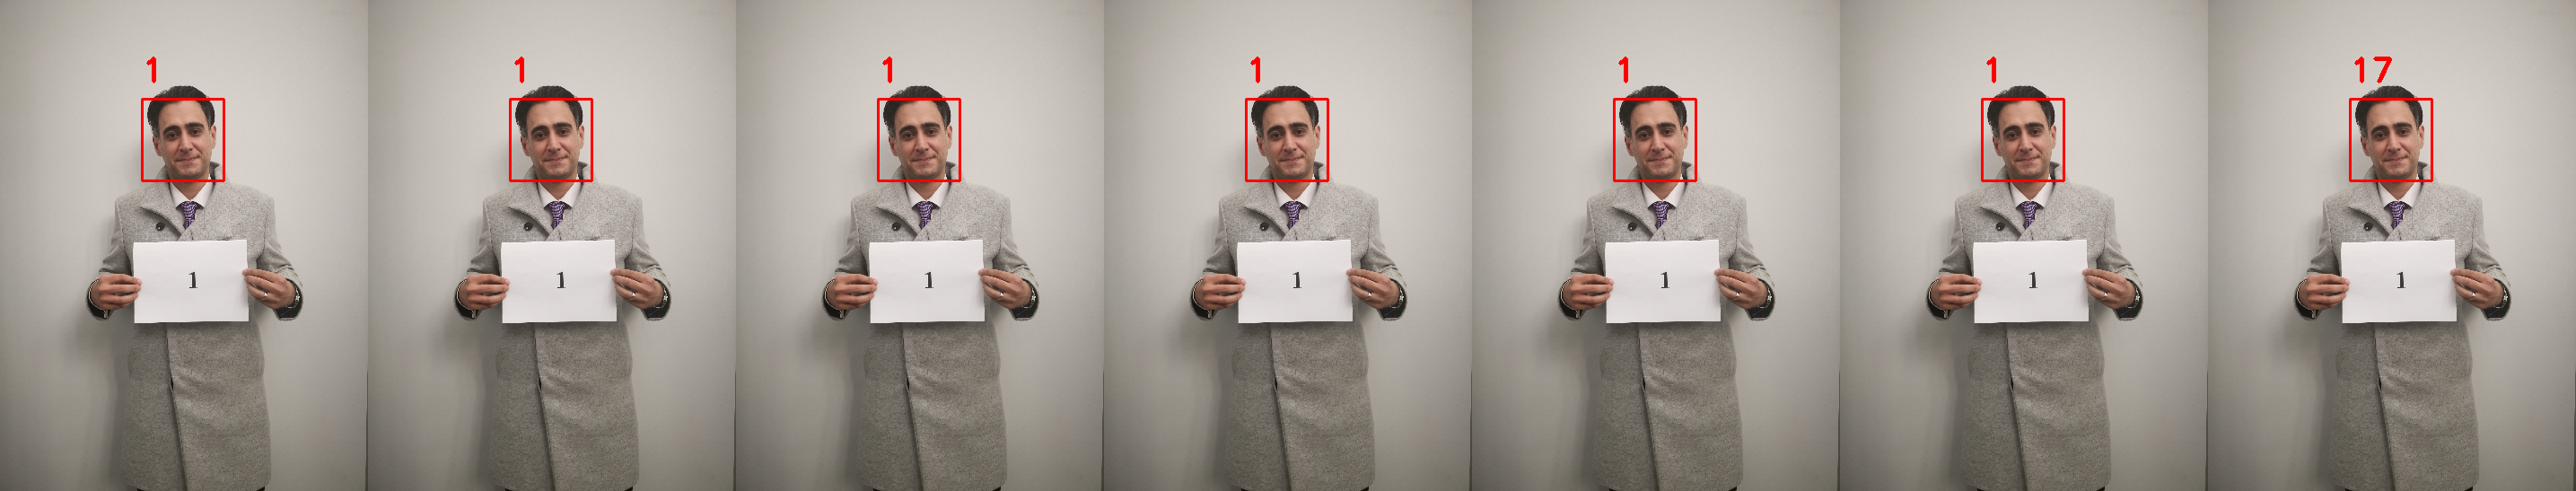

[['3' '188' '131']] [['69' '188' '131']] [['43' '188' '131']] [['3' '188' '131']] [['3' '188' '131']] [['43' '188' '131']] [['40' '188' '131']]


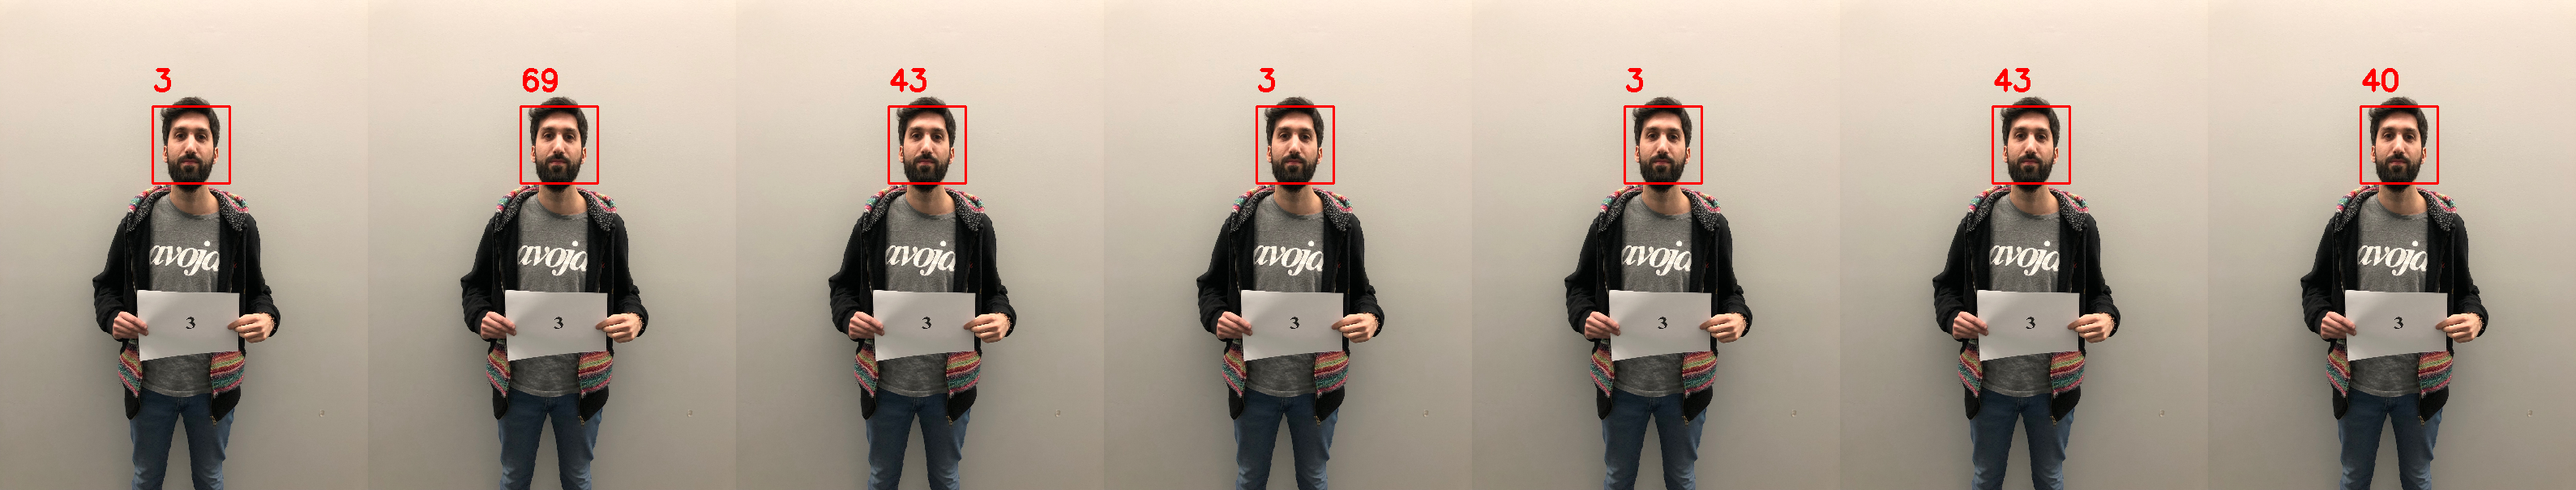

[['20' '176' '186']] [['40' '176' '186']] [['50' '176' '186']] [['22' '176' '186']] [['40' '176' '186']] [['77' '176' '186']] [['17' '176' '186']]


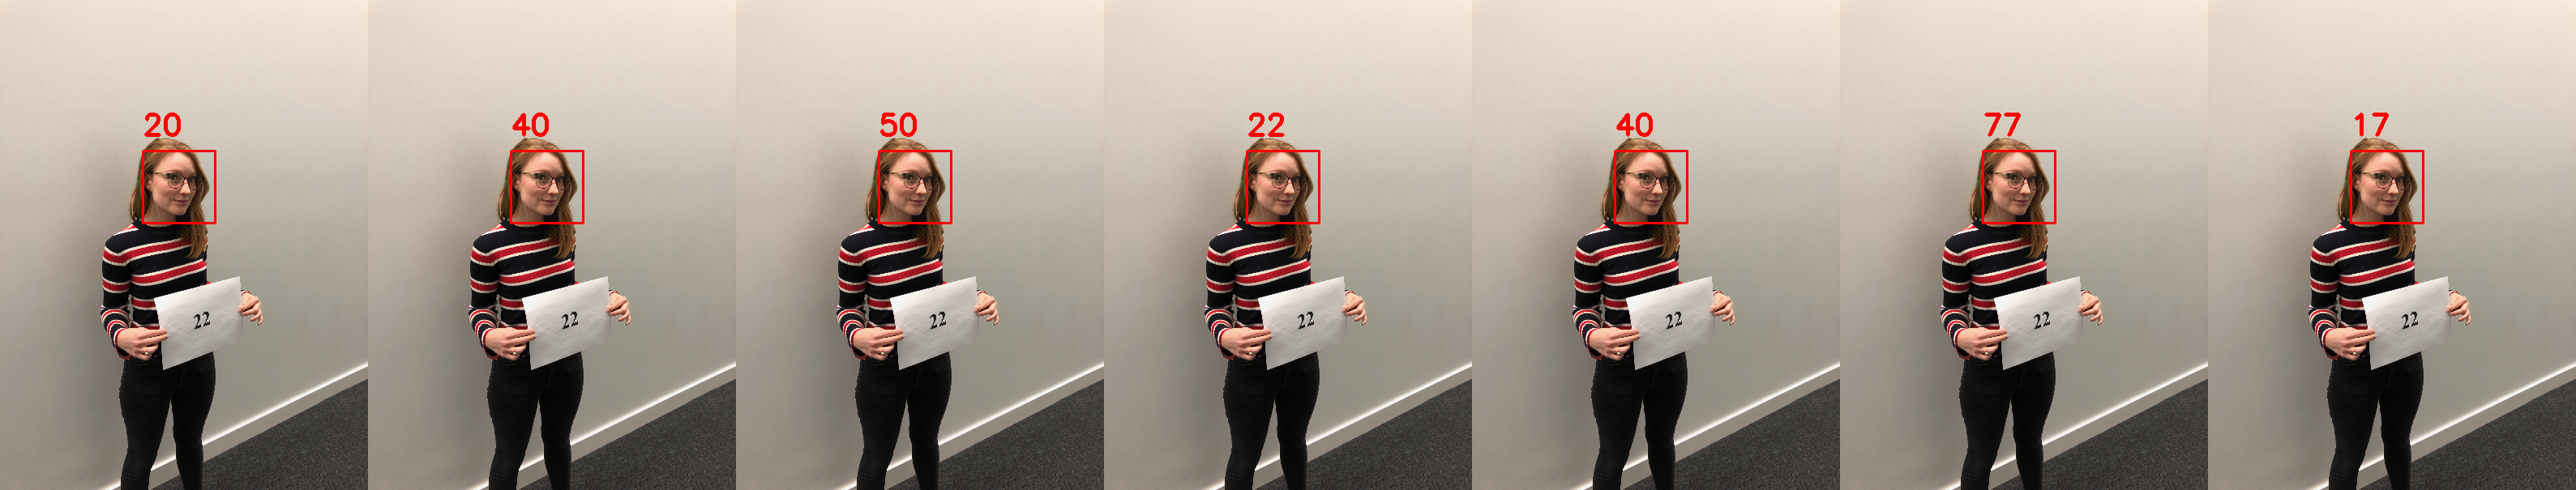

[['2' '164' '135']] [['73' '164' '135']] [['77' '164' '135']] [['2' '164' '135']] [['41' '164' '135']] [['53' '164' '135']] [['17' '164' '135']]


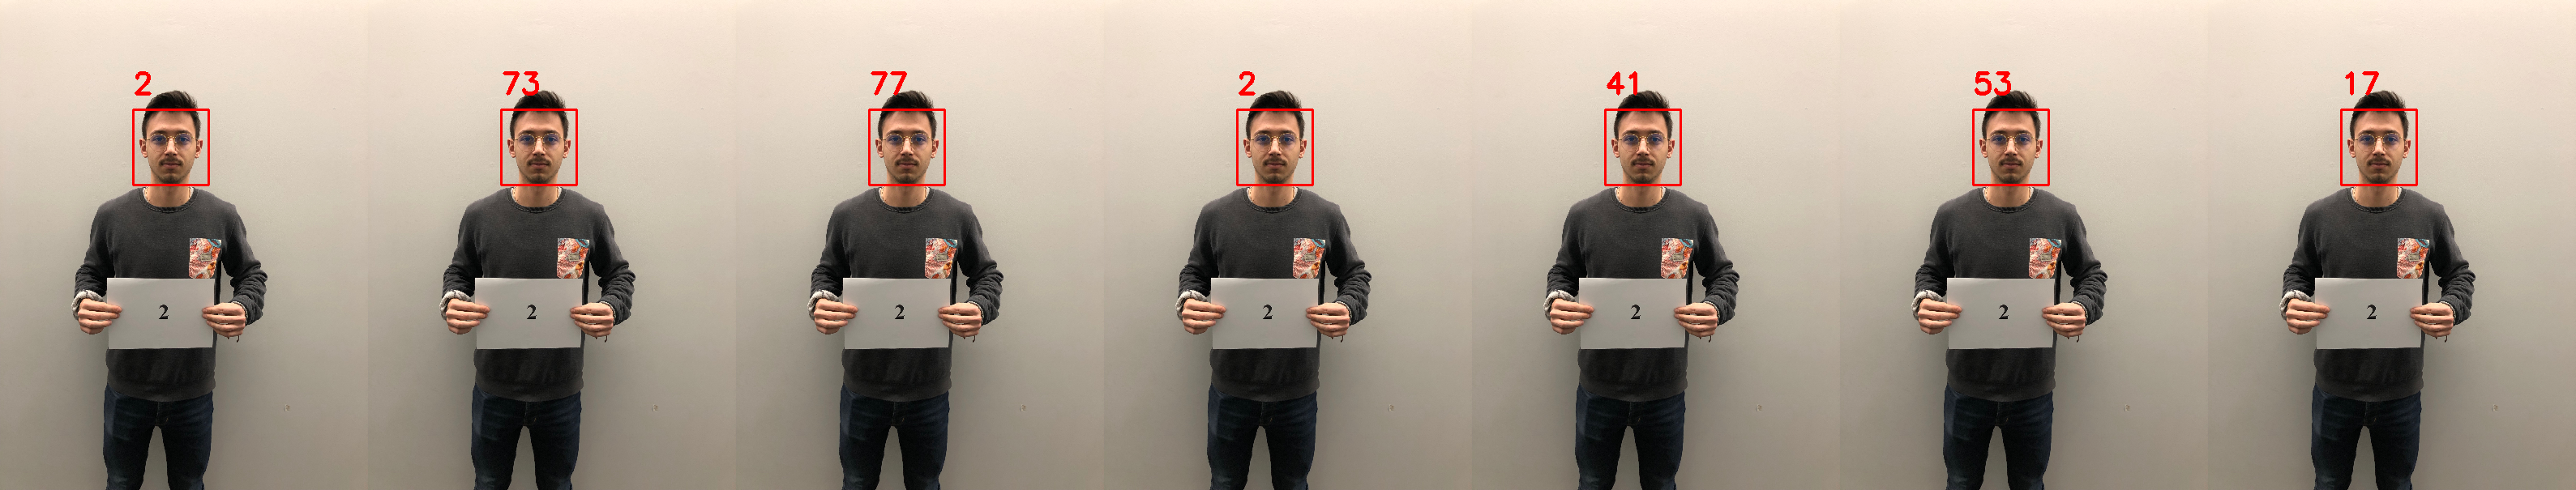

[['64' '190' '70']] [['74' '190' '70']] [['44' '190' '70']] [['67' '190' '70']] [['67' '190' '70']] [['77' '190' '70']] [['17' '190' '70']]


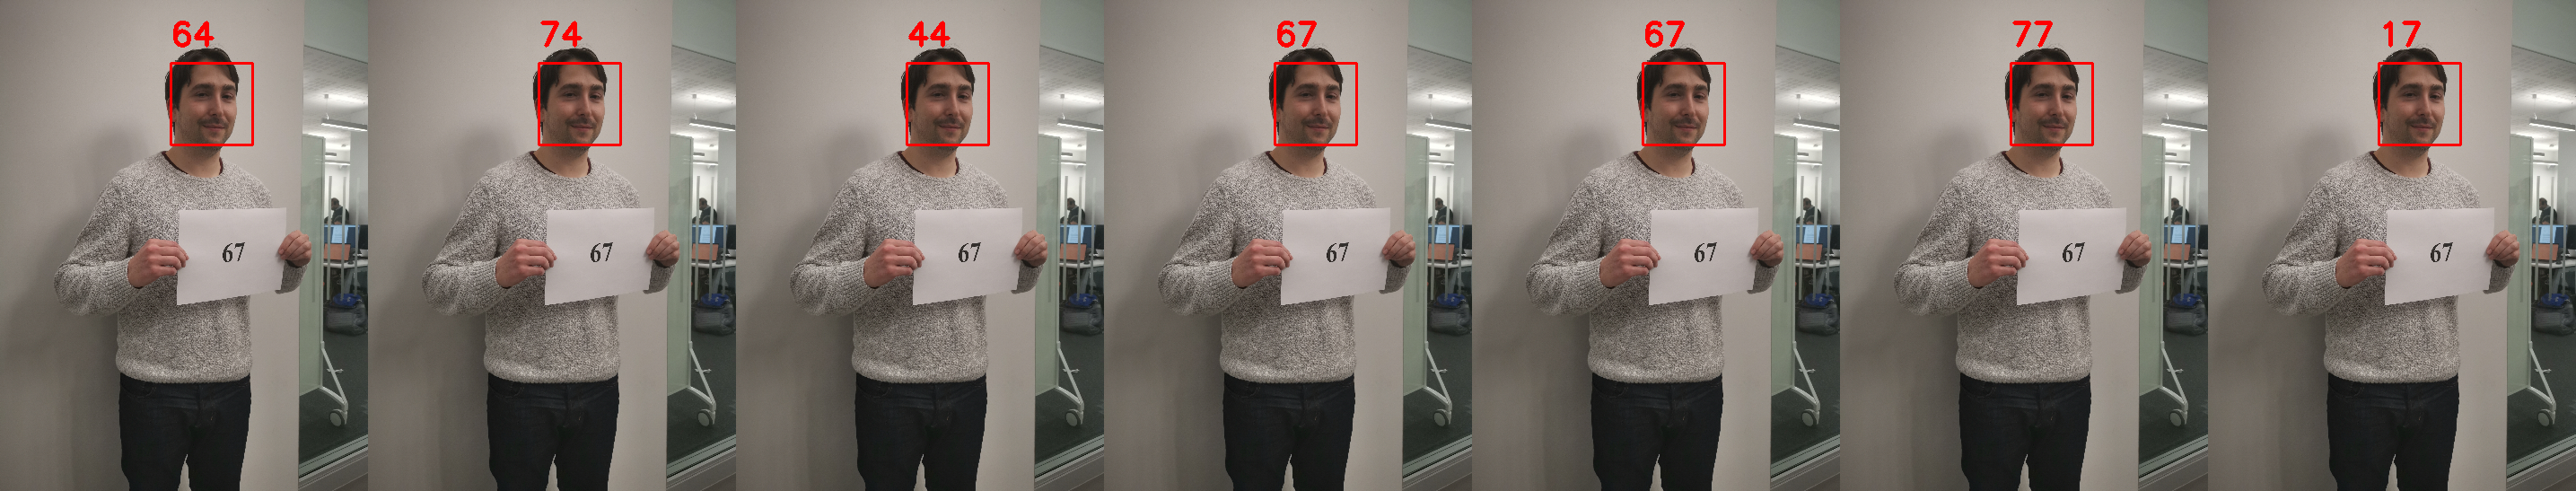

[['66' '178' '89']] [['37' '178' '89']] [['66' '178' '89']] [['66' '178' '89']] [['66' '178' '89']] [['66' '178' '89']] [['17' '178' '89']]


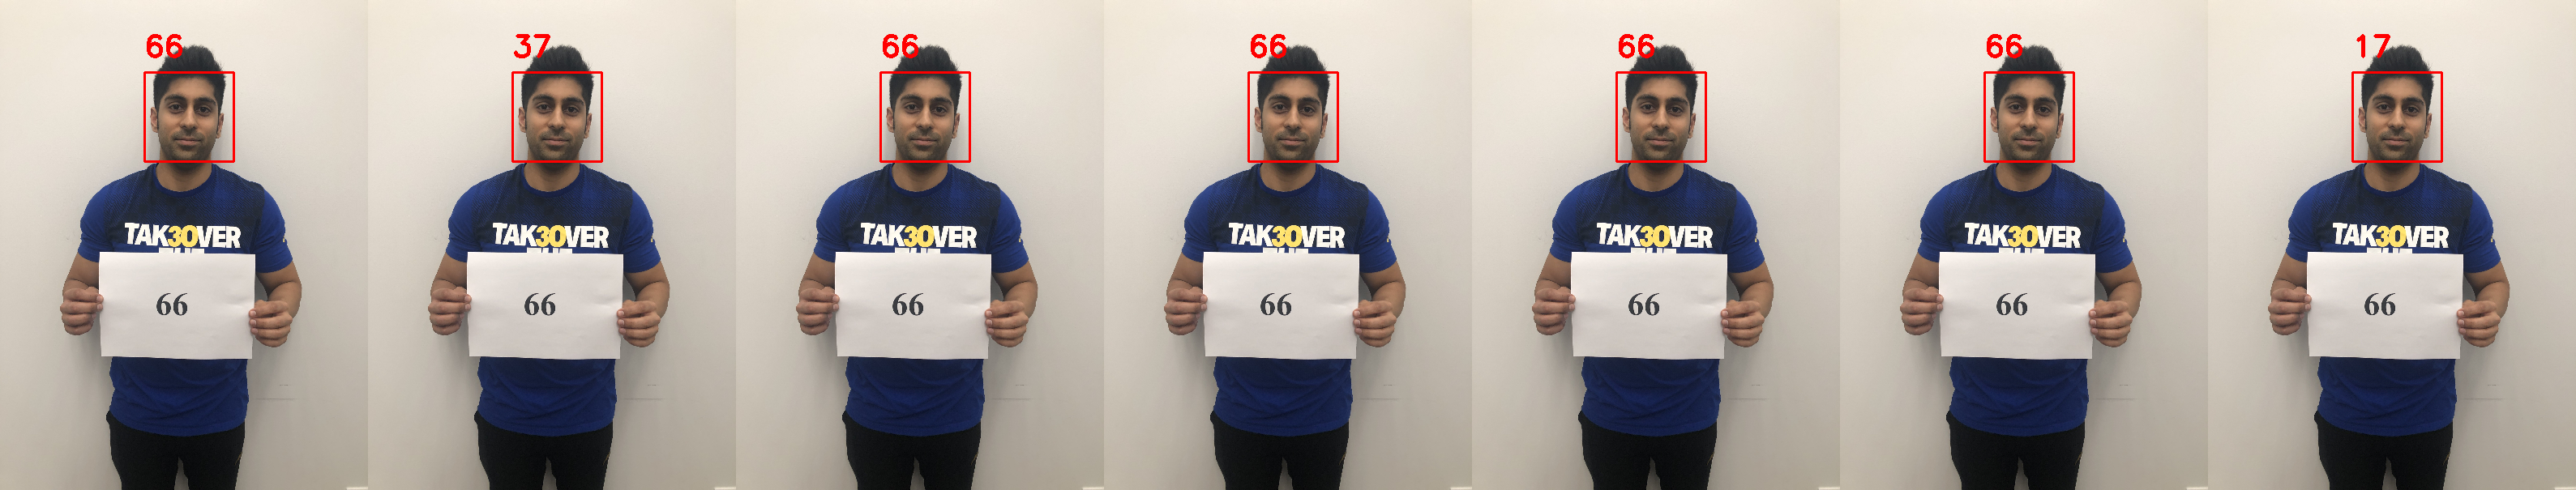

In [0]:
img_dir = "/content/drive/My Drive/City Msc Data Science/ComputerVision/Coursework2019/images" #<--- directory of images
VALID_LIST = ['.jpg', '.jpeg']

file_names = os.listdir(img_dir)
image_names = list(filter(lambda x: os.path.splitext(x)[1] in VALID_LIST, file_names)) # remove invalid file extensions

for name in image_names:
  
    file_path = os.path.join(img_dir, name)
    full_img = cv2.imread(file_path) # <-----insert image name directly
    img = cv2.resize(full_img, None, fx=0.15, fy=0.15)

    # Feel free to 
    mat1, img1 = recognize_face(img, 'sift' , 'svm')
    mat2, img2 = recognize_face(img, 'surf' , 'svm')
    mat3, img3 = recognize_face(img, 'orb' , 'svm')
    mat4, img4 = recognize_face(img, 'sift' , 'mlp')
    mat5, img5 = recognize_face(img, 'surf' , 'mlp')
    mat6, img6 = recognize_face(img, 'orb' , 'mlp')
    mat7, img7 = recognize_face(img, '' , 'cnn')
    
    
    #show matrixes
    print(mat1, mat2, mat3, mat4, mat5, mat6, mat7)
    
    # show images with prediction
    predictions =  np.hstack((img1, img2, img3, img4, img5, img6, img7))
    cv2_imshow(predictions)

### Past Tests

In [0]:
# Load sometest Images
%cd /content/drive/My\ Drive/City\ Msc\ Data\ Science/ComputerVision/Coursework2019/images


sophie_side = cv2.imread('sophie_side.jpeg')
jack = cv2.imread('jack.jpeg')
jack_side = cv2.imread('jack_side.jpeg')
sepher = cv2.imread('sepher.jpg')
elia = cv2.imread('elia.jpeg')
daniel = cv2.imread('daniel.jpeg')


#resize images since using cv2_imshow to show full size images takes a long time
sophie = cv2.resize(sophie_side, None, fx=0.15, fy=0.15)
jack = cv2.resize(jack, None, fx=0.15, fy=0.15)
jack_side = cv2.resize(jack_side, None, fx=0.15, fy=0.15)
sepher = cv2.resize(sepher, None, fx=0.15, fy=0.15)
elia = cv2.resize(elia, None, fx=0.15, fy=0.15)
daniel = cv2.resize(daniel, None, fx=0.15, fy=0.15)




/content/drive/My Drive/City Msc Data Science/ComputerVision/Coursework2019/images


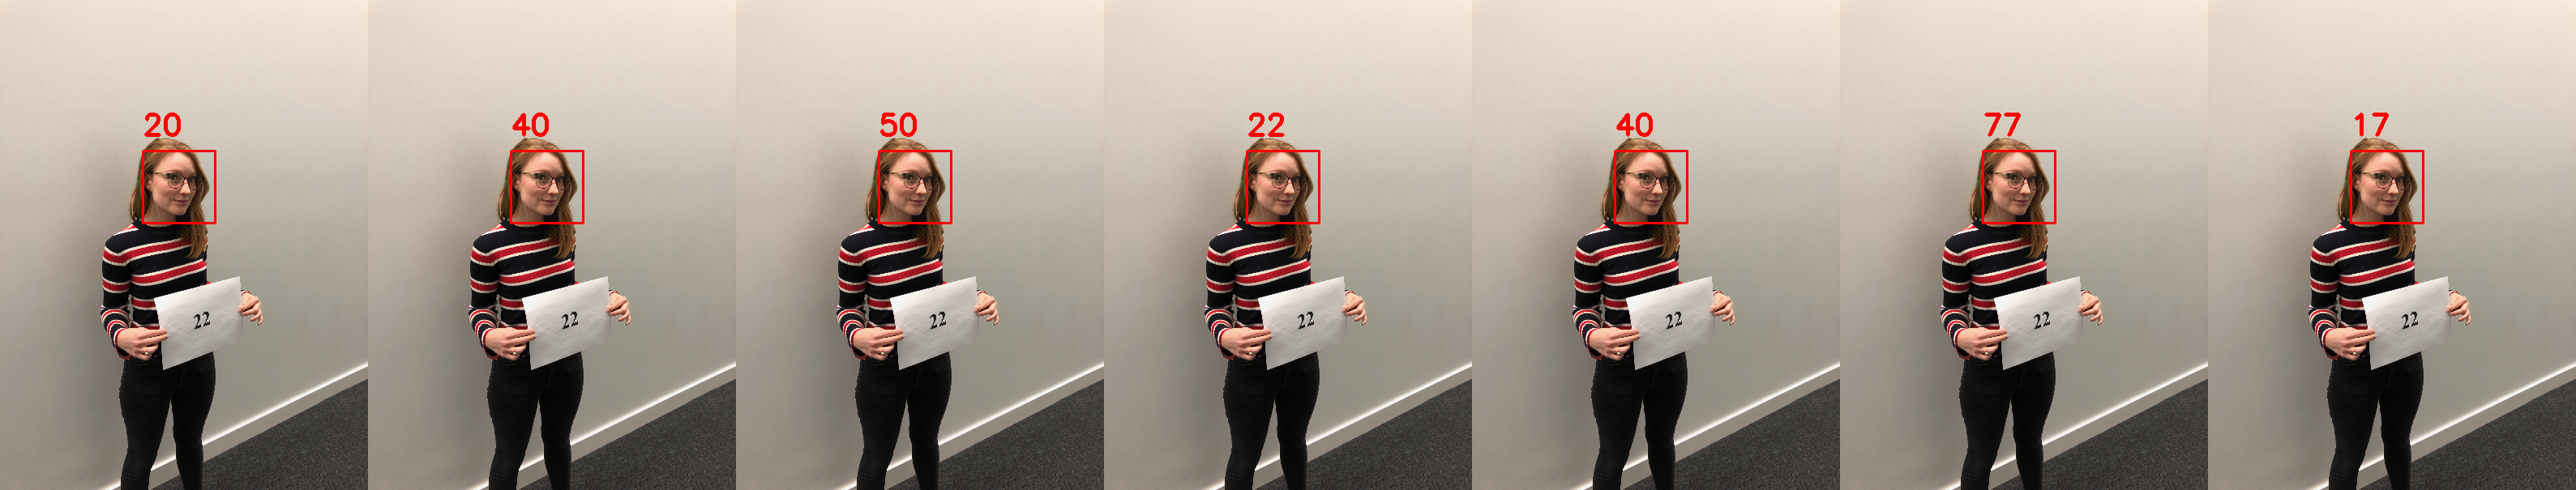

In [0]:
#sophie from side
mat1, img1 = recognize_face(sophie, 'sift' , 'svm')
mat2, img2 = recognize_face(sophie, 'surf' , 'svm')
mat3, img3 = recognize_face(sophie, 'orb' , 'svm')
mat4, img4 = recognize_face(sophie, 'sift' , 'mlp')
mat5, img5 = recognize_face(sophie, 'surf' , 'mlp')
mat6, img6 = recognize_face(sophie, 'orb' , 'mlp')
mat7, img7 = recognize_face(sophie, '' , 'cnn')

sophie_predictions =  np.hstack((img1, img2, img3, img4, img5, img6, img7))
cv2_imshow(sophie_predictions)



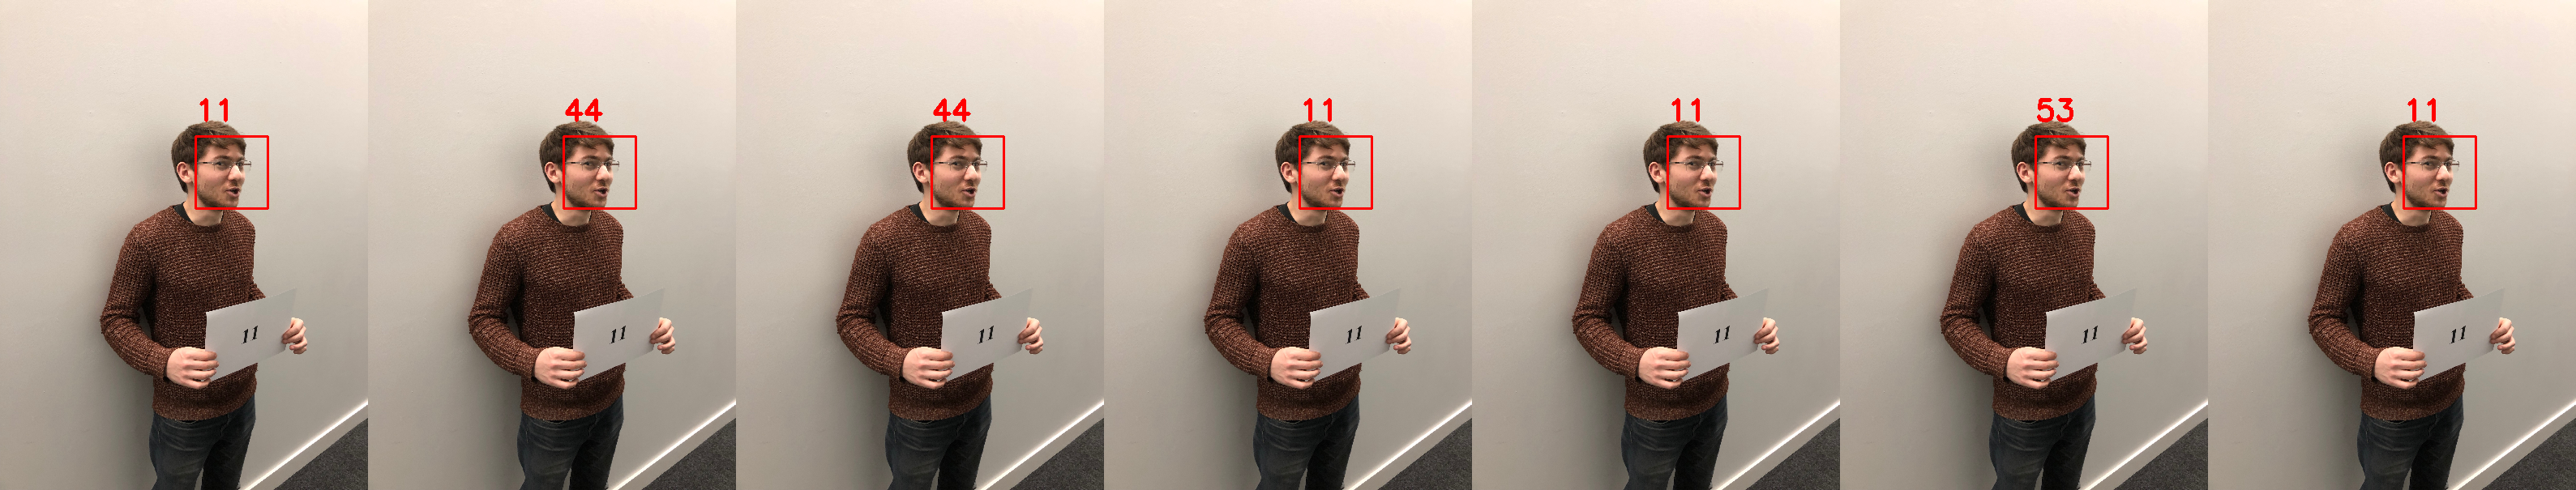

In [0]:
mat1, img1 = recognize_face(jack_side, 'sift' , 'svm')
mat2, img2 = recognize_face(jack_side, 'surf' , 'svm')
mat3, img3 = recognize_face(jack_side, 'orb' , 'svm')
mat4, img4 = recognize_face(jack_side, 'sift' , 'mlp')
mat5, img5 = recognize_face(jack_side, 'surf' , 'mlp')
mat6, img6 = recognize_face(jack_side, 'orb' , 'mlp')
mat7, img7 = recognize_face(jack_side, '' , 'cnn')

jack_side_predictions =  np.hstack((img1, img2, img3, img4, img5, img6, img7))
cv2_imshow(jack_side_predictions)


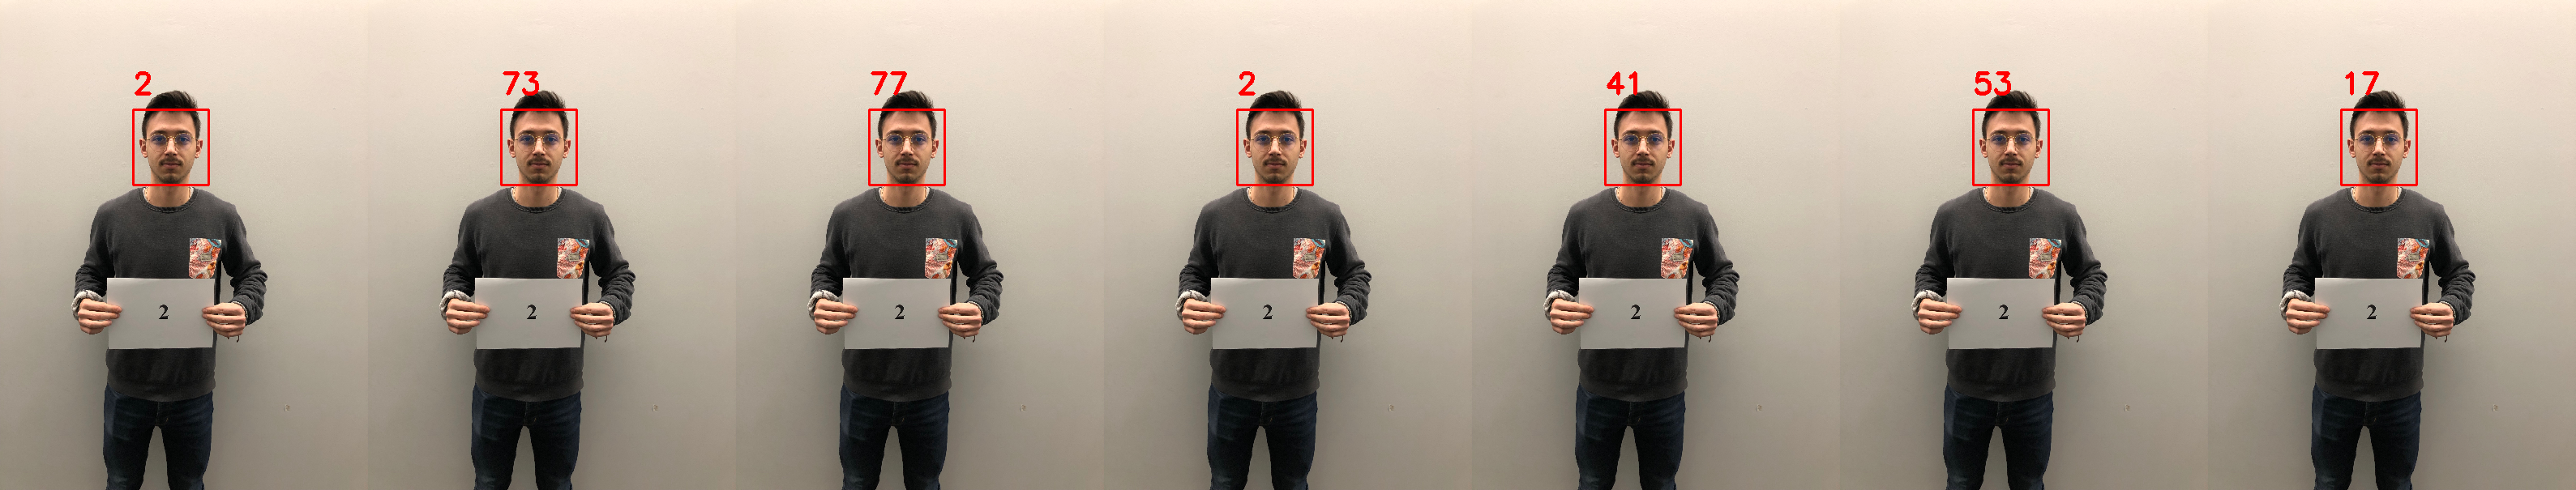

In [0]:
#Test Predictions

mat1, img1 = recognize_face(elia, 'sift' , 'svm')
mat2, img2 = recognize_face(elia, 'surf' , 'svm')
mat3, img3 = recognize_face(elia, 'orb' , 'svm')
mat4, img4 = recognize_face(elia, 'sift' , 'mlp')
mat5, img5 = recognize_face(elia, 'surf' , 'mlp')
mat6, img6 = recognize_face(elia, 'orb' , 'mlp')
mat7, img7 = recognize_face(elia, '' , 'cnn')

elia_predictions =  np.hstack((img1, img2, img3, img4, img5, img6, img7))
cv2_imshow(elia_predictions)


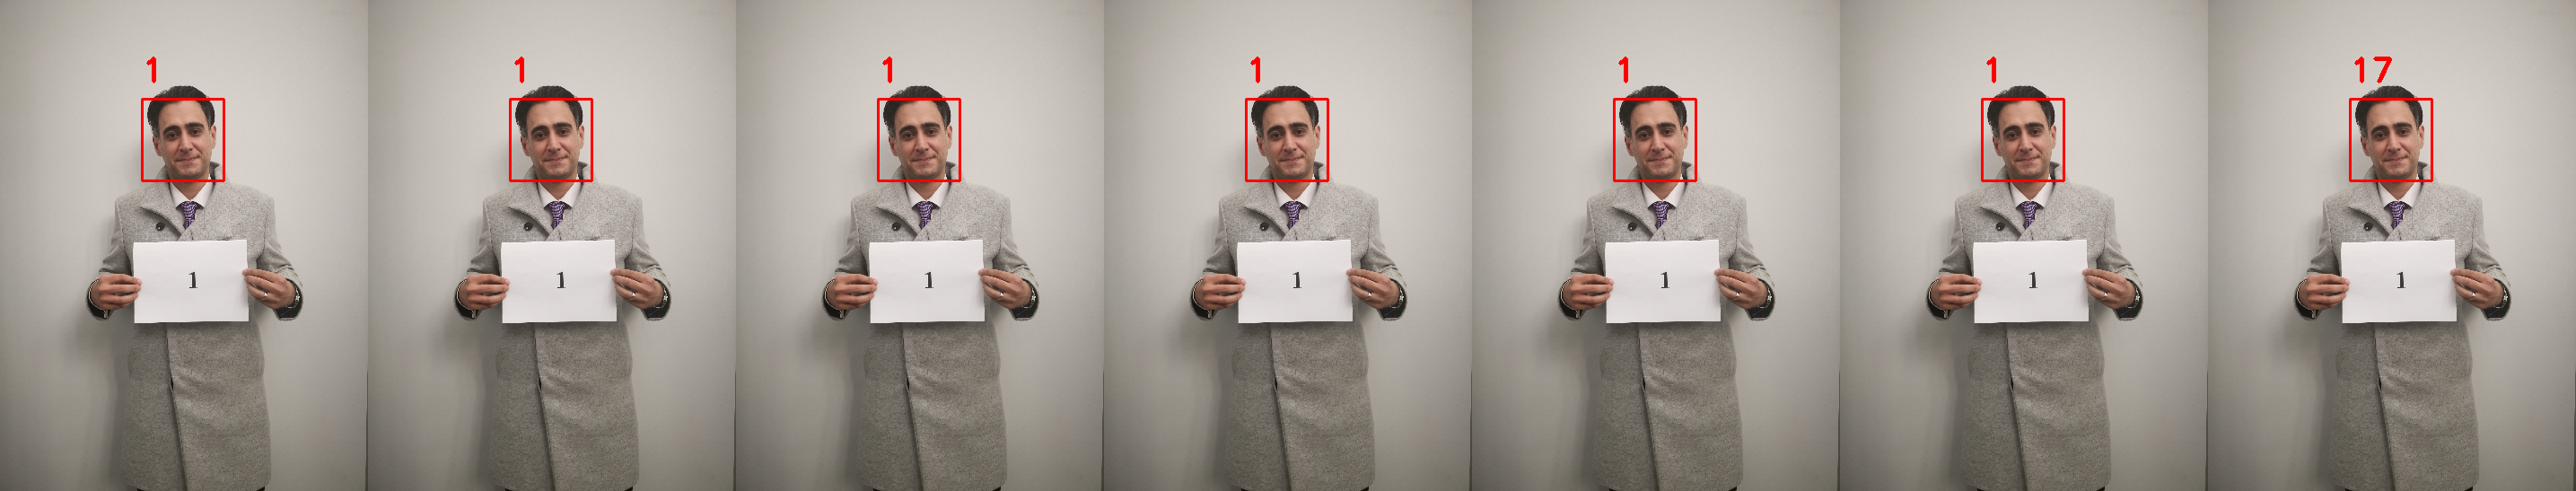

In [0]:

mat1, img1 = recognize_face(sepher, 'sift' , 'svm')
mat2, img2 = recognize_face(sepher, 'surf' , 'svm')
mat3, img3 = recognize_face(sepher, 'orb' , 'svm')
mat4, img4 = recognize_face(sepher, 'sift' , 'mlp')
mat5, img5 = recognize_face(sepher, 'surf' , 'mlp')
mat6, img6 = recognize_face(sepher, 'orb' , 'mlp')
mat7, img7 = recognize_face(sepher, '' , 'cnn')

sepher_predictions =  np.hstack((img1, img2, img3, img4, img5, img6, img7))
cv2_imshow(sepher_predictions)

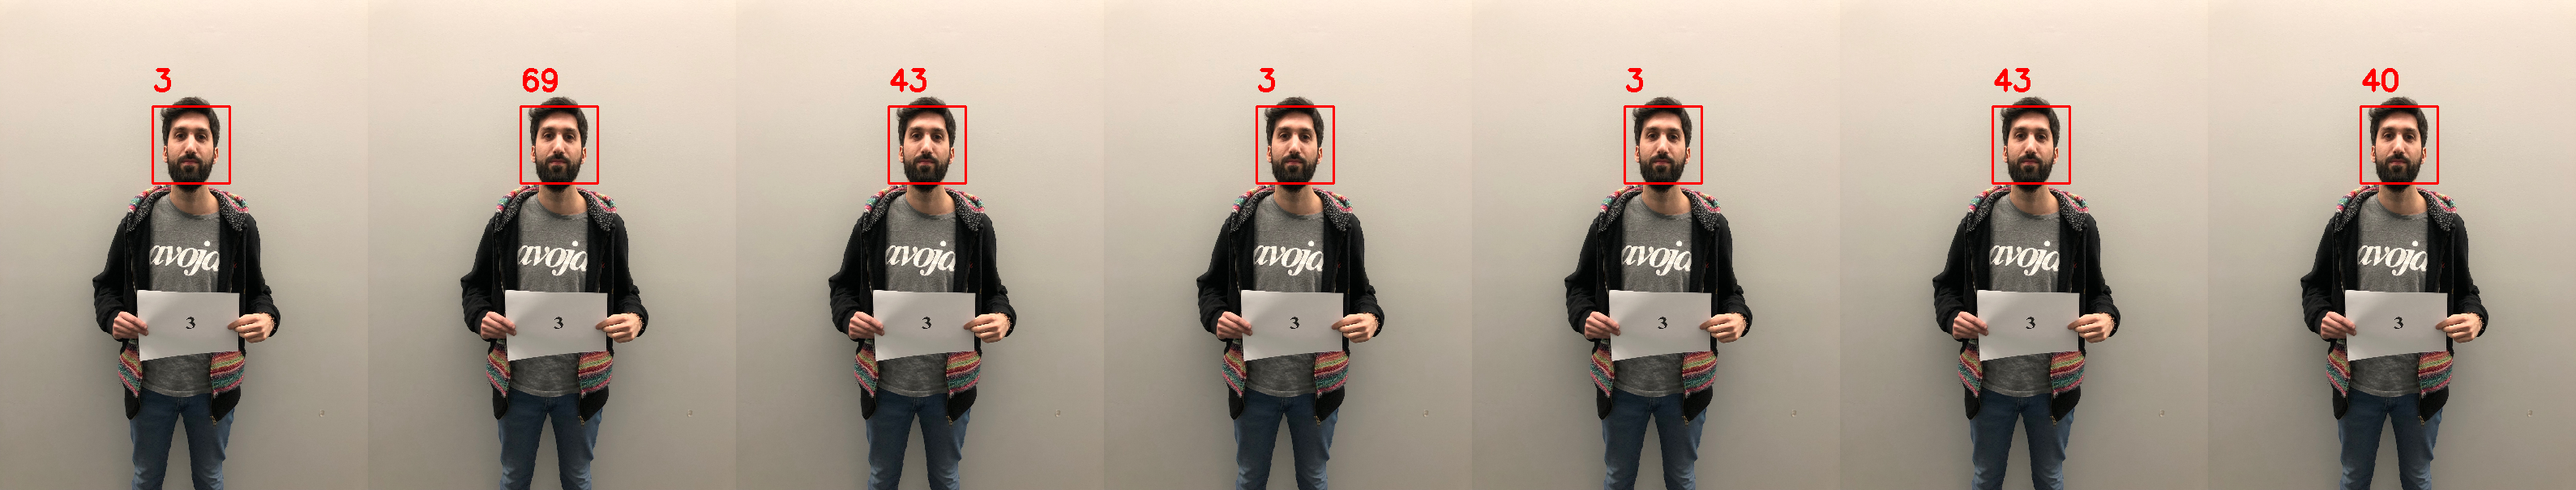

In [0]:

mat1, img1 = recognize_face(daniel, 'sift' , 'svm')
mat2, img2 = recognize_face(daniel, 'surf' , 'svm')
mat3, img3 = recognize_face(daniel, 'orb' , 'svm')
mat4, img4 = recognize_face(daniel, 'sift' , 'mlp')
mat5, img5 = recognize_face(daniel, 'surf' , 'mlp')
mat6, img6 = recognize_face(daniel, 'orb' , 'mlp')
mat7, img7 = recognize_face(daniel, '' , 'cnn')

daniel_predictions =  np.hstack((img1, img2, img3, img4, img5, img6, img7))
cv2_imshow(daniel_predictions)

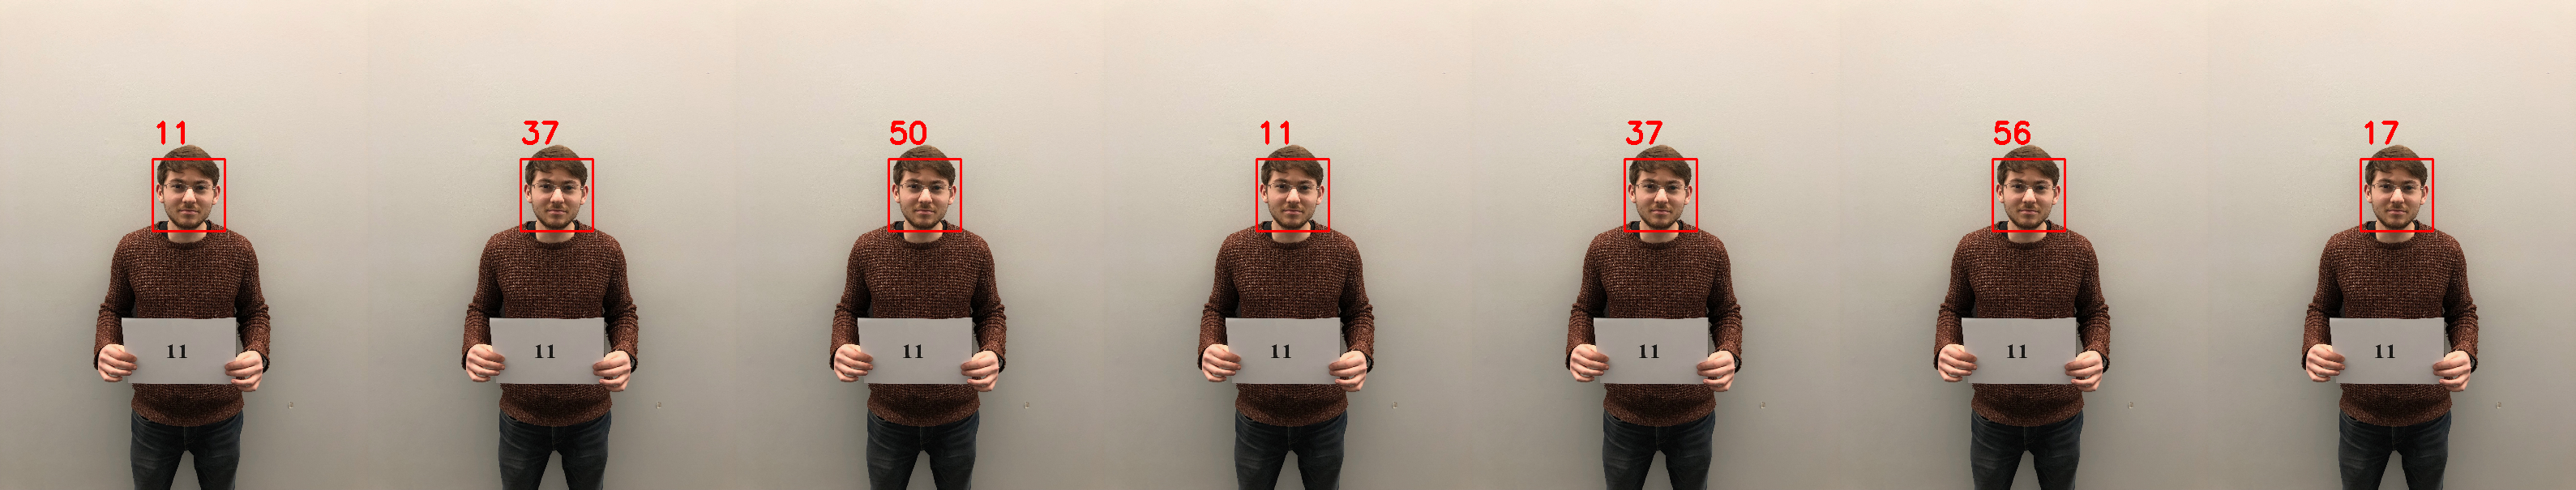

In [0]:

mat1, img1 = recognize_face(jack, 'sift' , 'svm')
mat2, img2 = recognize_face(jack, 'surf' , 'svm')
mat3, img3 = recognize_face(jack, 'orb' , 'svm')
mat4, img4 = recognize_face(jack, 'sift' , 'mlp')
mat5, img5 = recognize_face(jack, 'surf' , 'mlp')
mat6, img6 = recognize_face(jack, 'orb' , 'mlp')
mat7, img7 = recognize_face(jack, '' , 'cnn')

jack_predictions =  np.hstack((img1, img2, img3, img4, img5, img6, img7))
cv2_imshow(jack_predictions)